## Etapa 1: Importação das bibliotecas


In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

In [2]:
dropout = 0.5
epochs = 50
batch_size = 128
learning_rate=0.001
k = 5

In [5]:
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler 
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, accuracy_score,precision_score,f1_score,recall_score
from sklearn.metrics import plot_confusion_matrix ,roc_auc_score, roc_curve,auc
from sklearn.metrics import classification_report
import itertools
import time
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
import torch.nn.functional as F
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
import itertools
from scipy import interp
from itertools import cycle


In [6]:
def weight_reset(m):
    if isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):
        m.reset_parameters()

In [7]:
def L1(m, l1_lambda):
    l1_lambda = 0.001
    l1_norm = sum(p.abs().sum()
        for p in model.parameters())
 
    return l1_lambda * l1_norm

def L2(m, l2_lambda):
    l2_lambda = 0.001
    l2_norm = sum(p.pow(2.0).sum()
        for p in model.parameters())
 
    return l2_lambda * l2_norm

In [8]:
class Fold:
    def __init__(self):
        self.train_loss      = []
        self.train_accuracy  = [] 
        self.test_loss       = []
        
        self.test_accuracy   = []
        self.test_precision  = []
        self.test_recall     = []
        self.test_f1_score   = []
        self.test_specificity= []

        self.major_accuracy  = 0
        
        # Não utilizados no treinamento e teste
        self.last_pred       = np.array([], dtype=int) 
        self.last_true       = np.array([], dtype=int) 
        self.last_score      = np.array([], dtype=float) 

        
        self.accuracy    = 0.
        self.precision   = 0.
        self.recall      = 0.
        self.specificity = 0.
        self.f1          = 0.
       
        self.confusion_matrix=[]


In [9]:
class DenseNeuralNetwork(nn.Module):
    def __init__(self):
        super(DenseNeuralNetwork, self).__init__()
        
        self.dense1 = nn.Sequential(
            nn.Linear(n_previsores, n_hiden),
            nn.BatchNorm1d(n_hiden),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.dense2 = nn.Sequential(
            nn.Linear(n_hiden, n_hiden),
            nn.BatchNorm1d(n_hiden),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
          
        self.dense3 = nn.Linear(n_hiden, n_classes)

    def forward(self, X):
        X = self.dense1(X)
        X = self.dense2(X)
        X = self.dense3(X)
        return X

In [10]:
class Cnn1dNeuralNetwork(nn.Module):
    def __init__(self):
        super(Cnn1dNeuralNetwork, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv1d(1, out_channels = 16,  kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            #nn.Dropout(dropout),            
            nn.MaxPool1d(2)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv1d(16,32 , kernel_size=3, stride=1, padding=1),            
            nn.BatchNorm1d(32),
            nn.ReLU(),
            #nn.Dropout(dropout),            
            nn.MaxPool1d(2)
        )
     
        
        
        self.flatten1 = nn.Flatten()

        self.dense1 = nn.Sequential( 
            nn.Linear(320, 230),
            nn.BatchNorm1d(230),
            nn.ReLU(),
            nn.Dropout(dropout)
        )   
        
        
        self.dense2 = nn.Sequential( 
            nn.Linear(230, 230),
            nn.BatchNorm1d(230),
            nn.ReLU(),
            nn.Dropout(dropout)
        )  
       
        self.dense3 = nn.Linear(230, n_classes)            

    def forward(self, X):
        X = self.conv1(X)
        X = self.conv2(X)
        X = self.flatten1(X)
        X = self.dense1(X)
        X = self.dense2(X)
        X = self.dense3(X)
        return X

In [11]:
base = pd.read_csv('datasets/output_full.csv',sep=';',usecols = 
                   
    [
    'forward_pl_mean','forward_piat_mean','forward_pps_mean','forward_bps_mean',
    'forward_pl_var','forward_piat_var','forward_pps_var','forward_bps_var',
    'forward_pl_q1','forward_pl_q3','forward_piat_q1','forward_piat_q3',
    'forward_pl_max','forward_pl_min','forward_piat_max','forward_piat_min',
    'forward_pps_max','forward_pps_min','forward_bps_max','forward_bps_min',
    'reverse_pl_mean','reverse_piat_mean','reverse_pps_mean','reverse_bps_mean',
    'reverse_pl_var','reverse_piat_var','reverse_pps_var','reverse_bps_var',
    'reverse_pl_q1','reverse_pl_q3','reverse_piat_q1','reverse_piat_q3',
    'reverse_pl_max','reverse_pl_min','reverse_piat_max','reverse_piat_min',
    'reverse_pps_max','reverse_pps_min','reverse_bps_max','reverse_bps_min',
    'category'
   ])

base = base[base.category.isin([
    'CHAT-ICQ',
    'CHAT-GMAIL',
    'CHAT-FACEBOOK',
    'CHAT-HANGOUTS',
    
    'FILE-SFTP-DOWN',
    'FILE-SKYPE',
    'FILE-FTPS',
    
    'STR-SPOTIFY',
    'STR-VIMEO',
    'STR-YOUTUBE',
    'STR-NETFLIX', 
    
    'VIDEO-SKYPE',
    'VIDEO-HANGOUTS',
    
    'AUDIO-VOIPBUSTER',
    'AUDIO-SKYPE',
    'AUDIO-HANGOUTS',
    'AUDIO-FACEBOOK',
    'EMAIL',
    
])]

In [12]:
base.shape

(5976, 41)

In [13]:
base = shuffle(base)
base.head()

,forward_pl_mean,forward_piat_mean,forward_pps_mean,forward_bps_mean,forward_pl_var,forward_piat_var,forward_pps_var,forward_bps_var,forward_pl_q1,forward_pl_q3,...,reverse_piat_q3,reverse_pl_max,reverse_pl_min,reverse_piat_max,reverse_piat_min,reverse_pps_max,reverse_pps_min,reverse_bps_max,reverse_bps_min,category
963,118.719770,1.717755,3.761531,596.638747,34586.097961,7.335461,120.796643,3.915680e+06,0.000000,150.456522,...,0.794250,1480.612022,66.000000,10.105000,0.012977,77.060046,0.098961,111404.293204,6.531420,STR-SPOTIFY
898,119.703519,1.689611,3.861564,607.504708,35260.326352,6.947155,124.800013,4.045173e+06,0.000000,150.456522,...,0.789000,1480.612022,66.000000,10.105000,0.012977,77.060046,0.098961,111404.293204,6.531420,STR-SPOTIFY
2649,112.386697,2.696815,0.429602,70.625366,15702.513624,1.190606,0.061553,1.707075e+04,60.000000,60.000000,...,2.945333,503.000000,0.000000,5.058000,0.000000,2.678040,0.000000,1007.439000,0.000000,CHAT-GMAIL
1493,72.800770,0.016374,121.379990,8705.400701,46.807322,0.000078,15584.332769,7.795108e+07,70.456171,71.554806,...,0.021349,1523.310127,1441.205128,0.025923,0.002232,447.972305,38.575668,676767.457962,57972.106825,STR-NETFLIX
661,373.622926,4.938161,107.217864,114251.790210,316505.739906,17.880613,27527.958218,4.529562e+10,60.000000,74.000000,...,10.080500,1411.906165,60.000000,10.132000,0.002462,406.120024,0.098697,539878.793890,5.921832,FILE-SKYPE


In [14]:
# Separando previsores e classes
base_columns= len(base.columns)-1
previsores = base.iloc[ :, :base_columns]
classe = base.iloc[ :, base_columns]

In [15]:
previsores

,forward_pl_mean,forward_piat_mean,forward_pps_mean,forward_bps_mean,forward_pl_var,forward_piat_var,forward_pps_var,forward_bps_var,forward_pl_q1,forward_pl_q3,...,reverse_piat_q1,reverse_piat_q3,reverse_pl_max,reverse_pl_min,reverse_piat_max,reverse_piat_min,reverse_pps_max,reverse_pps_min,reverse_bps_max,reverse_bps_min
963,118.719770,1.717755,3.761531,596.638747,34586.097961,7.335461e+00,120.796643,3.915680e+06,0.000000,150.456522,...,0.000000,0.794250,1480.612022,66.000000,10.105000,0.012977,77.060046,0.098961,111404.293204,6.531420
898,119.703519,1.689611,3.861564,607.504708,35260.326352,6.947155e+00,124.800013,4.045173e+06,0.000000,150.456522,...,0.000000,0.789000,1480.612022,66.000000,10.105000,0.012977,77.060046,0.098961,111404.293204,6.531420
2649,112.386697,2.696815,0.429602,70.625366,15702.513624,1.190606e+00,0.061553,1.707075e+04,60.000000,60.000000,...,2.264675,2.945333,503.000000,0.000000,5.058000,0.000000,2.678040,0.000000,1007.439000,0.000000
1493,72.800770,0.016374,121.379990,8705.400701,46.807322,7.768349e-05,15584.332769,7.795108e+07,70.456171,71.554806,...,0.007693,0.021349,1523.310127,1441.205128,0.025923,0.002232,447.972305,38.575668,676767.457962,57972.106825
661,373.622926,4.938161,107.217864,114251.790210,316505.739906,1.788061e+01,27527.958218,4.529562e+10,60.000000,74.000000,...,0.002822,10.080500,1411.906165,60.000000,10.132000,0.002462,406.120024,0.098697,539878.793890,5.921832
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2870,44.833333,1.440000,0.351942,23.979950,1237.305556,1.839305e+00,0.142335,5.464844e+02,0.000000,72.000000,...,0.000000,2.632333,199.500000,0.000000,3.362667,0.000000,0.659631,0.000000,89.709763,0.000000
1611,78.500000,4.918500,0.203314,15.960150,0.000000,0.000000e+00,0.000000,0.000000e+00,78.500000,78.500000,...,9.837000,9.837000,60.000000,60.000000,9.837000,9.837000,0.101657,0.101657,6.099421,6.099421
2138,110.966614,2.789020,0.674198,94.633350,1614.026746,5.227357e+00,0.453347,1.855654e+04,79.000000,143.937500,...,1.135212,3.780500,780.000000,96.333333,10.085000,0.207000,4.830918,0.099157,711.487088,77.342588
3321,166.670194,0.974281,1.246207,275.111517,1352.264146,1.548671e-02,3.362262,7.631184e+05,162.000000,162.000000,...,0.963355,1.009600,146.000000,146.000000,1.119889,0.534000,1.872659,0.892946,273.408240,130.370076


In [16]:
classe_label = np.unique(base['category'])
len(classe_label)
classe_label

array(['AUDIO-FACEBOOK', 'AUDIO-HANGOUTS', 'AUDIO-SKYPE',
       'AUDIO-VOIPBUSTER', 'CHAT-FACEBOOK', 'CHAT-GMAIL', 'CHAT-HANGOUTS',
       'CHAT-ICQ', 'EMAIL', 'FILE-FTPS', 'FILE-SFTP-DOWN', 'FILE-SKYPE',
       'STR-NETFLIX', 'STR-SPOTIFY', 'STR-VIMEO', 'STR-YOUTUBE',
       'VIDEO-HANGOUTS', 'VIDEO-SKYPE'], dtype=object)

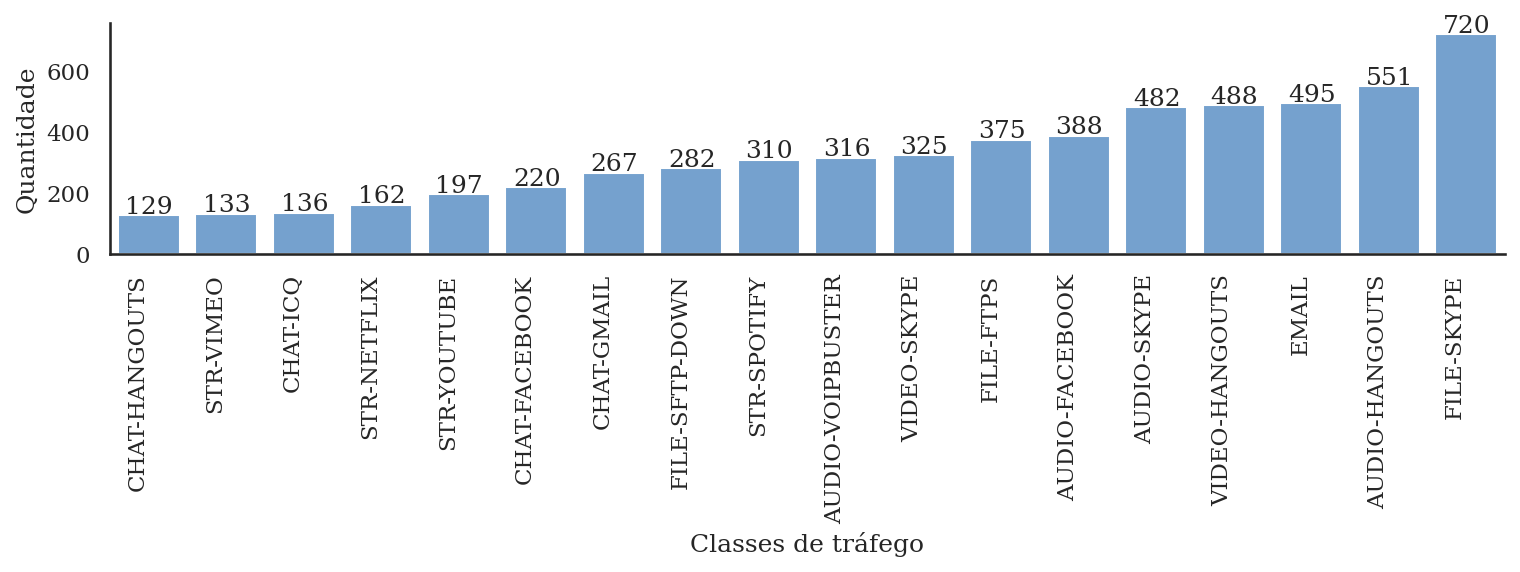

In [29]:
sns.set(rc={"figure.dpi":150, 'savefig.dpi':150})


#sns.set_style("darkgrid")
total=(base["category"].shape[0])*1.
#palette_pub_cubehelix = sns.cubehelix_palette(len(classe_label), start=3, rot=0, reverse=True)

sns.set(rc={"figure.figsize":(12, 2)})
sns.set_style("white")
sns.set_style({'font.family':'serif', 'font.serif':['Times New Roman']})

res=sns.countplot(x=base["category"], 
                 orient="V",
                  palette=["#66A1DD"],
                 #palette=palette_pub_cubehelix,
                 order=base['category'].value_counts( ).sort_values().index
                )
res.set_xticklabels(res.get_xticklabels(), rotation=90, ha="right")
res.set(xlabel='Classes de tráfego', ylabel='Quantidade')

for p in res.patches:
        res.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+5))

#for p in res.patches:
#        res.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))

#ax.yaxis.set_ticks(np.linspace(0, total, 11))     

#res.yaxis.set_ticks(np.linspace(0, total, 11))     


#_ = res.set_yticklabels(map('{:.1f}%'.format, 100*res.yaxis.get_majorticklocs()))
_ = res.set_yticklabels(map('{:.0f}'.format, res.yaxis.get_majorticklocs()))
res.spines.right.set_visible(False)
res.spines.top.set_visible(False)


In [16]:
# transformando dados categoricos em numéricos
encoder = LabelEncoder()
classe = encoder.fit_transform(classe)

In [17]:
# normalizando dados
#scaler =  MinMaxScaler()
scaler = StandardScaler()
previsores = scaler.fit_transform(previsores)

In [18]:
#  calculo de  neurônios
n_previsores=np.shape(previsores)[1]
n_classes = len(np.unique(classe))
n_hiden=int((np.shape(previsores)[1] + len(np.unique(classe)))/2)

#n_hiden=50


In [19]:
print(n_previsores,n_hiden,n_classes)

40 29 18


In [20]:
model = DenseNeuralNetwork()

In [21]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr = learning_rate,
   # weight_decay = 0.0001
                      )

In [22]:
kf = KFold(n_splits=k, random_state=None)

accuracy_stack = np.array([], dtype=float) 
precision_stack = np.array([], dtype=float) 
recall_stack = np.array([], dtype=float) 
specificity_stack = np.array([], dtype=float) 
f1_score_stack = np.array([], dtype=float) 

matriz_score = []

train_accu=[]
train_loss=[]

test_accu=[]
test_loss=[]

In [23]:
device=torch.device("cuda:0" if torch.cuda.is_available else "cpu")
#device='cpu'
print(device)
model.to(device)

cuda:0


DenseNeuralNetwork(
  (dense1): Sequential(
    (0): Linear(in_features=40, out_features=29, bias=True)
    (1): BatchNorm1d(29, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
  )
  (dense2): Sequential(
    (0): Linear(in_features=29, out_features=29, bias=True)
    (1): BatchNorm1d(29, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
  )
  (dense3): Linear(in_features=29, out_features=18, bias=True)
)

In [24]:
sns.set(rc={"figure.dpi":100, 'savefig.dpi':100})
sns.set_context('notebook')
sns.set_style("darkgrid")

In [25]:
folds=[]
y_score = np.empty((0,n_classes), float)
y_true  = np.array([], dtype=int) 
y_pred  = np.array([], dtype=int) 

for i in range(k):
    folds.append(Fold())

# indexador de fold
j=0

start_time = time.perf_counter()

for train_index , test_index in kf.split(previsores):
    #print('Fold %3d: ' % (j+1))
    previsores_treinamento, previsores_teste = previsores[train_index,:], previsores[test_index,:]
    classe_treinamento, classe_teste = classe[train_index] , classe[test_index]
    
    previsores_treinamento = torch.tensor(previsores_treinamento, dtype=torch.float)
    classe_treinamento = torch.tensor(classe_treinamento, dtype=torch.long)
    
    previsores_teste = torch.tensor(previsores_teste, dtype=torch.float)
    classe_teste = torch.tensor(classe_teste, dtype=torch.long)
    
    train_dataset = torch.utils.data.TensorDataset(previsores_treinamento, classe_treinamento)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True,drop_last=True)
    
    test_dataset = torch.utils.data.TensorDataset(previsores_teste, classe_teste)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle = True,drop_last=True)
        
    for epoch in range(epochs):
        
        model.train()
        
        running_loss = 0.
        running_accuracy = 0.
      
        for data in train_loader:
            
            inputs, labels = data
            inputs, labels = inputs.to(device),labels.to(device)

            #print(inputs.shape)
            # zera os gradientes
            optimizer.zero_grad()

            # Valores das previsões
            outputs = model.forward(inputs)
        
            # Calculo do erro
            loss = criterion(outputs, labels)
            
            #loss = loss +  L1(model, 0.0001) + L2(model, 0.0001)

            
            # inicia o processo de backpropagation
            loss.backward()
            
            # recria os valores das previsões passando a função softmax, retonando as probabilidades
            outputs = F.softmax(outputs)
             
            
            
            top_p, top_class = outputs.topk(k = 1, dim = 1)
    
            equals = top_class == labels.view(*top_class.shape)
    
            running_accuracy += torch.mean(equals.type(torch.float)).item()
            
            #atualiza os pesos
            optimizer.step()
        
            # acumula o total da época
            running_loss += loss.item()
        
            # outputs = [np.argmax(t) for t in outputs.detach().numpy()]
            # Isso desconectará o tensor da GPU, passará para cpu e depois converterá para numpy.
            outputs = [np.argmax(t) for t in outputs.detach().cpu().numpy()]

        
        folds[j].train_accuracy.append(running_accuracy/len(train_loader))
        folds[j].train_loss.append(running_loss/len(train_loader))

        
        model.eval()
    
        running_loss = 0.
        running_accuracy = 0.
    
        for data in test_loader:
           
            # cada iteração é um batch, não esquecer disso.
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # optimizer.zero_grad()
    
            outputs = model.forward(inputs)
        
            loss = criterion(outputs, labels)
            #loss = loss +  L1(model, 0.0001) + L2(model, 0.0001)

            # loss.backward()
            # optimizer.step()
            
            outputs = F.softmax(outputs)

            y_score = np.vstack((y_score, outputs.detach().cpu().numpy()))
            # Isso desconectará o tensor da GPU, passará para cpu e depois converterá para numpy.
            y_true   =  np.concatenate((y_true ,[np.argmax(t) for t in outputs.detach().cpu().numpy()]))
            # Isso desconectará o tensor da GPU, passará para cpu e depois converterá para numpy.
            y_pred  =  np.concatenate((y_pred, labels.detach().cpu().numpy()))
            
           
            top_p, top_class = outputs.topk(k = 1, dim = 1)
    
            equals = top_class == labels.view(*top_class.shape)
    
            running_accuracy += torch.mean(equals.type(torch.float)).item()
            
            running_loss += loss.item()
        
        folds[j].test_loss.append(running_loss/len(test_loader))
        
        folds[j].test_accuracy.append(running_accuracy/len(test_loader))
        folds[j].test_precision.append(precision_score( y_true, y_pred,average='macro'))
        folds[j].test_recall.append(recall_score( y_true, y_pred,average='macro'))
        folds[j].test_f1_score.append(f1_score( y_true, y_pred,average='macro'))

    
        #folds[j].confusion_matrix   = confusion_matrix(y_true , y_pred)
        
        color_text = "\33[30m"
        if ((epoch == 0) or (folds[j].test_accuracy[-1] > folds[j].major_accuracy)):
            color_text = "\33[34m"
            folds[j].major_accuracy = folds[j].test_accuracy[-1]
       
        
        #if epoch==0:
        #    print("Na mão {:.5f}".format(running_accuracy/len(test_loader)))
        #    print("Na mão {:.5f}".format(accuracy_score( y_true, y_pred)))
       
    
        #np.append(folds[j].last_true, y_true, axis=0)
        #np.append(folds[j].last_pred, y_true, axis=0)
        
        #print(y_score.shape,y_true.shape,y_pred.shape)
        
        # guarda 
        folds[j].last_score = y_score
        folds[j].last_true = y_true
        folds[j].last_pred= y_pred
        
        
        # zera os armazenadores que servirão para formar a MC do Fold
        y_true  = np.array([], dtype=int) 
        y_pred  = np.array([], dtype=int)
        y_score = np.empty((0,n_classes), float)
        
       
        print('%s(%2d|%3d): %.10f;%.10f;%.10f;%.10f\033[m' % (
        #print('%s(%2d|%3d): %.10f;%.10f;%.10f;%.10f\033[m' % (
            color_text,
            j+1,
            epoch + 1,
            #folds[j].train_loss[-1], 
           # folds[j].train_accuracy[-1],
            #folds[j].test_loss[-1], 
            folds[j].test_accuracy[-1],
            #folds[j].train_loss[-1]/folds[j].test_loss[-1],
            #folds[j].test_accuracy[-1]/folds[j].train_accuracy[-1]
            folds[j].test_precision[-1],
            folds[j].test_recall[-1],
            folds[j].test_f1_score[-1],
        ))
        
        
    # armazena em um vetor a última acurácia de testes de cada fold
    j+=1
    
    #reseta todos os pesos da redes para valores randômicos
    model.apply(weight_reset)
    
end_time = time.perf_counter()

( 1|  1): 0.2890625000;0.2057769965;0.2153850859;0.1502055871
( 1|  2): 0.2994791667;0.2138959463;0.1613744403;0.1550180565
( 1|  3): 0.3038194444;0.2167411795;0.2170723008;0.1586849810
( 1|  4): 0.3715277778;0.2763402608;0.3463853663;0.2281018010
( 1|  5): 0.4756944444;0.3595631342;0.3437903971;0.3192727873
( 1|  6): 0.5355902778;0.4029782828;0.3583609417;0.3495747509
( 1|  7): 0.5642361111;0.4351851255;0.4089187008;0.3868668875
( 1|  8): 0.5625000000;0.4192633368;0.3467705960;0.3597711255
( 1|  9): 0.5850694444;0.4486694701;0.3812984525;0.3889732577
( 1| 10): 0.5894097222;0.4487138136;0.3771379154;0.3889126549
( 1| 11): 0.6041666667;0.4735483416;0.4072153045;0.4182557833
( 1| 12): 0.6276041667;0.5089516366;0.4236172710;0.4465356698
( 1| 13): 0.6397569444;0.5335229524;0.5093005435;0.4832905445
( 1| 14): 0.6493055556;0.5397128806;0.5373498568;0.4886527395
( 1| 15): 0.6710069444;0.5845335625;0.5692827341;0.5455460367
( 1| 16): 0.7222222222;0.6449990169;0.5880665140;0.6003081316
( 1| 17)

( 3| 20): 0.7387152778;0.6899956183;0.7371304405;0.6743216101
( 3| 21): 0.7526041667;0.7053699066;0.7463753989;0.6866243918
( 3| 22): 0.7656250000;0.7230722157;0.8139215620;0.7118434499
( 3| 23): 0.7447916667;0.7119995871;0.7483645006;0.6985887054
( 3| 24): 0.7803819444;0.7309613201;0.7844952489;0.7252585247
( 3| 25): 0.7847222222;0.7377580730;0.8202327776;0.7335703181
( 3| 26): 0.8020833333;0.7548524375;0.8109518759;0.7493540085
( 3| 27): 0.7838541667;0.7375931102;0.8163840220;0.7255215978
( 3| 28): 0.7864583333;0.7452739487;0.7992011866;0.7332957268
( 3| 29): 0.7864583333;0.7406660905;0.7935158774;0.7305970588
( 3| 30): 0.8116319444;0.7674924609;0.8274672516;0.7575578705
( 3| 31): 0.7838541667;0.7418373618;0.8122231616;0.7324721662
( 3| 32): 0.8125000000;0.7634999364;0.8059285523;0.7548386568
( 3| 33): 0.8020833333;0.7618718783;0.8181918811;0.7493262432
( 3| 34): 0.8203125000;0.7728339200;0.8218572671;0.7610732372
( 3| 35): 0.8185763889;0.7777693127;0.8186584232;0.7644895649
( 3| 36)

( 5| 39): 0.8307291667;0.7873154320;0.8036446784;0.7782361371
( 5| 40): 0.8142361111;0.7725400049;0.8011742822;0.7640671435
( 5| 41): 0.8159722222;0.7711317096;0.7953130109;0.7632111208
( 5| 42): 0.8307291667;0.7873653319;0.8020201902;0.7763988484
( 5| 43): 0.8263888889;0.7757632671;0.8561338010;0.7699900379
( 5| 44): 0.8151041667;0.7703005318;0.7921937729;0.7573064707
( 5| 45): 0.8350694444;0.7878049740;0.8101100889;0.7797871922
( 5| 46): 0.8376736111;0.7904168147;0.7979832169;0.7779769820
( 5| 47): 0.8333333333;0.7895252247;0.8557695684;0.7783698174
( 5| 48): 0.8211805556;0.7761707403;0.7921650979;0.7616017636
( 5| 49): 0.8237847222;0.7823427404;0.8043241618;0.7735847090
( 5| 50): 0.8368055556;0.7907832889;0.8084796432;0.7800155378


### Acurácia por Fold

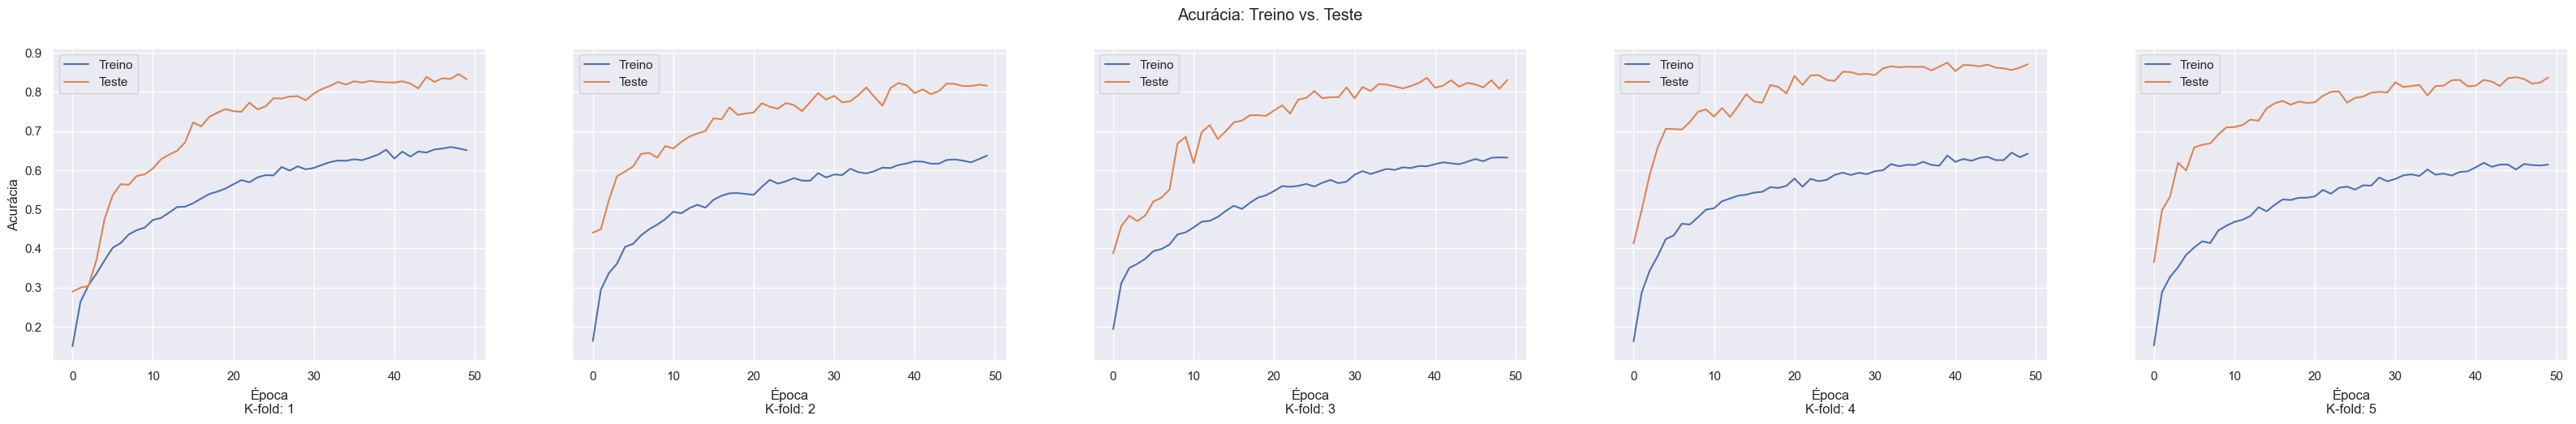

In [26]:
fig, axes = plt.subplots(1, k, figsize=(40, 5), sharey=True)
fig.suptitle('Acurácia: Treino vs. Teste')
i=0
for i in range(k):
    res= sns.lineplot(
            ax=axes[i],
            data=[folds[i].train_accuracy,
            folds[i].test_accuracy],
            markers=False, 
            dashes=False,   
            )
    res.set(xlabel='Época\nK-fold: {:d}'.format(i+1), ylabel='Acurácia')
    res.legend(labels=["Treino","Teste"])   

### Perda por Fold

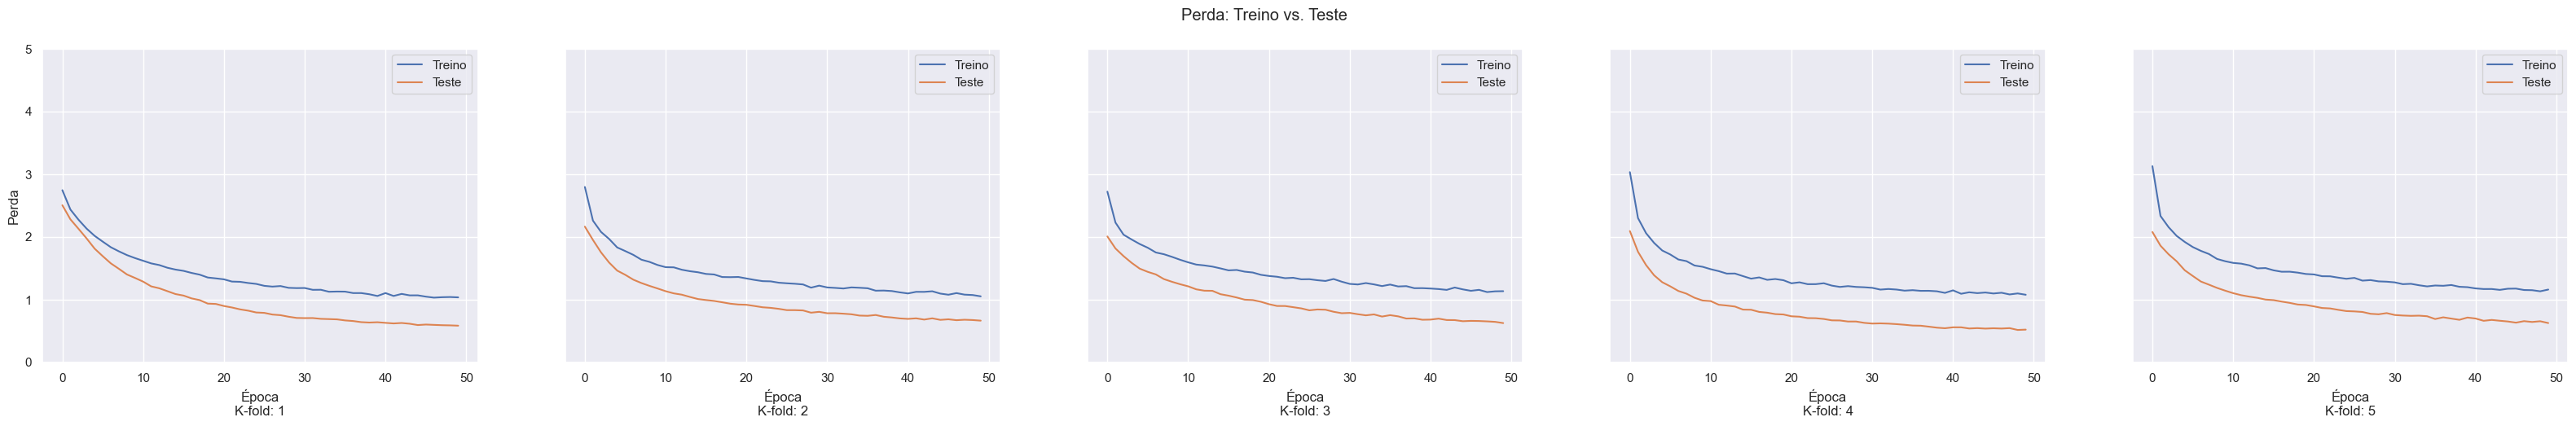

In [27]:
fig, axes = plt.subplots(1, k, figsize=(40,k ), sharey=True, sharex=True)
fig.suptitle('Perda: Treino vs. Teste')
i=0
for i in range(k):
    res= sns.lineplot(
        ax=axes[i],
        data=[
            folds[i].train_loss,
            folds[i].test_loss],
        markers=False, 
        dashes=False    
        )

    res.set(xlabel='Época\nK-fold: {:d}'.format(i+1), ylabel='Perda')
    res.legend(labels=["Treino","Teste"])
    plt.ylim(0, 5)

In [28]:
for i in range(k):
    folds[i].confusion_matrix = confusion_matrix(folds[i].last_true, folds[i].last_pred)
    folds[i].accuracy = accuracy_score( folds[i].last_true.reshape(-1), folds[i].last_pred.reshape(-1),normalize = True)
    folds[i].precision = precision_score( folds[i].last_true.reshape(-1), folds[i].last_pred.reshape(-1),average='macro')
    folds[i].recall = recall_score( folds[i].last_true.reshape(-1), folds[i].last_pred.reshape(-1),average='macro')
    folds[i].f1_score = f1_score( folds[i].last_true.reshape(-1), folds[i].last_pred.reshape(-1),average='macro')
    
    accuracy_stack = np.append(accuracy_stack,folds[i].accuracy) 
    precision_stack = np.append(precision_stack,folds[i].precision) 
    recall_stack = np.append(recall_stack,folds[i].recall) 
    f1_score_stack = np.append(f1_score_stack,folds[i].f1_score) 

    

### Matriz de confusão por Fold

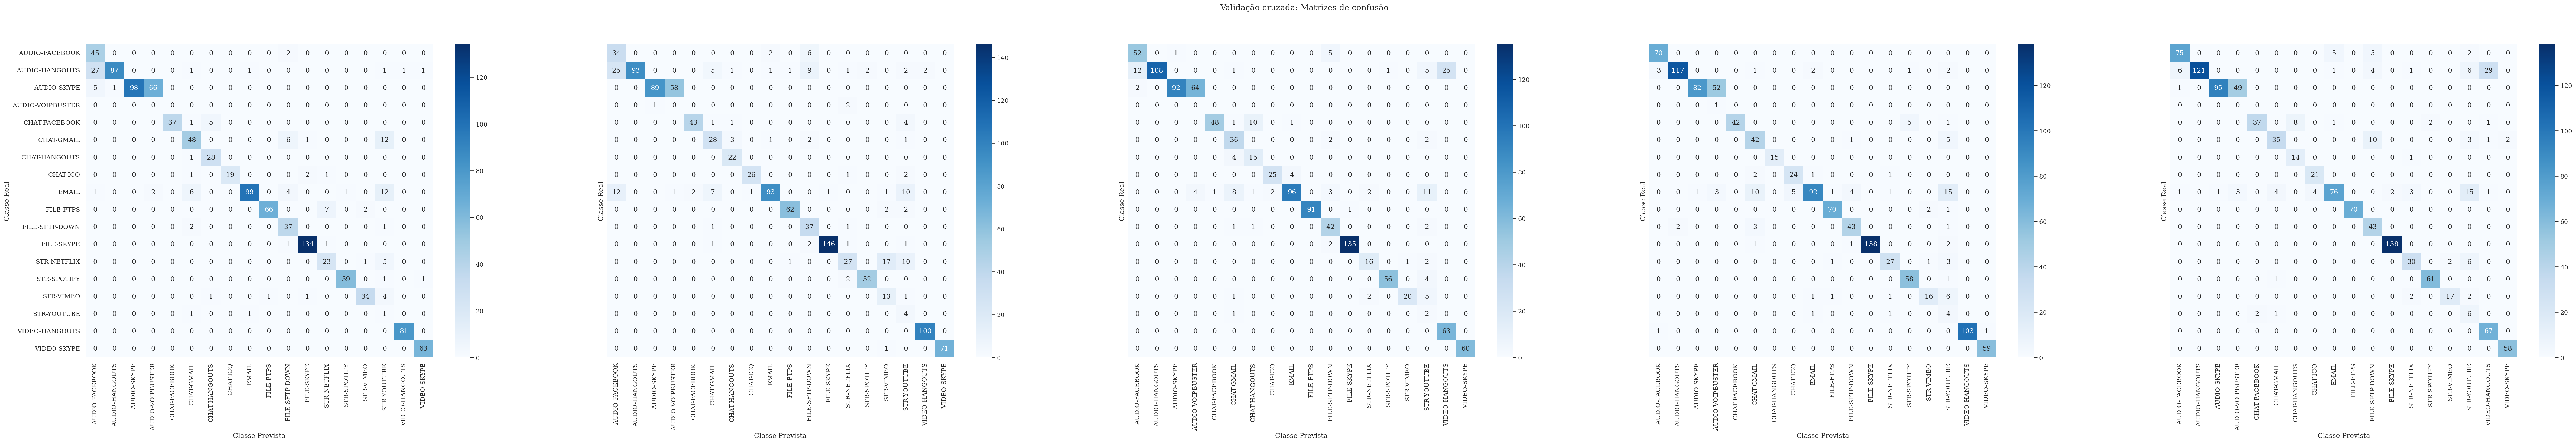

In [29]:
i=0
sns.set(rc={"figure.dpi":150, 'savefig.dpi':150})
sns.set_context('notebook')

#sns.set_style("darkgrid")
sns.set_style({'font.family':'serif', 'font.serif':['Times New Roman']})

fig, axes = plt.subplots(1, k, figsize=(80, 10), sharey=True)
fig.suptitle('Validação cruzada: Matrizes de confusão')

for i in range(k):
    res= sns.heatmap(folds[i].confusion_matrix,
                ax=axes[i],
                annot = True,
                linecolor='black',
                xticklabels=classe_label,
                yticklabels=classe_label,
                cmap="Blues" ,
                    fmt='g')
    res.set(xlabel='Classe Prevista',ylabel='Classe Real')
    #res.axhline(y = 0, color = 'k',linewidth = 2) 
    #res.axhline(y = len(classe_label), color = 'k', linewidth = 2) 
    #res.axvline(x = 0, color = 'k', linewidth = 2) 
    #res.axvline(x = len(classe_label), color = 'k', linewidth = 2)

In [30]:
#variancia = accuracy_stack.std() ** 2
print('Tempo de Treino + teste: {0:.10f} sec'.format(end_time - start_time))
#print('Variancia da acurácia: {0:.5f}'.format((variancia)))


print("Fold\tAcc.\tPrec\tRec\tF1-s")
for i in range(k):
#    print("{:d}\t{:0.5f}\t{:0.5f}\t{:0.5f}\t{:0.5f}\t{:0.5f}".format(i+1,
    print("{:d}\t{:0.5f}\t{:0.5f}\t{:0.5f}\t{:0.5f}".format(i+1,
                                                                     
                                                                     folds[i].accuracy,
                                                                     folds[i].precision,
                                                                     folds[i].recall,
                                                                     #folds[i].specificity,
                                                                     folds[i].f1_score 
                                                                    ))
    

Tempo de Treino + teste: 48.9004663000 sec
Fold	Acc.	Prec	Rec	F1-s
1	0.83247	0.80318	0.78548	0.77755
2	0.81597	0.75772	0.81078	0.74588
3	0.83073	0.78610	0.79638	0.76690
4	0.87066	0.83108	0.87596	0.81022
5	0.83681	0.79078	0.80848	0.78002


In [31]:
matrizes = [] 
total_accuracy = []
total_precision = []
total_recall = []
total_specificity = []
total_f1_score = []


for i in range(k):
    matrizes.append(folds[i].confusion_matrix)
    total_accuracy.append( folds[i].accuracy)
    total_precision.append( folds[i].precision)
    total_recall.append( folds[i].recall)
    total_specificity.append( folds[i].specificity)
    total_f1_score.append( folds[i].f1_score)

In [32]:
matriz_final = np.mean(matrizes, axis=0)


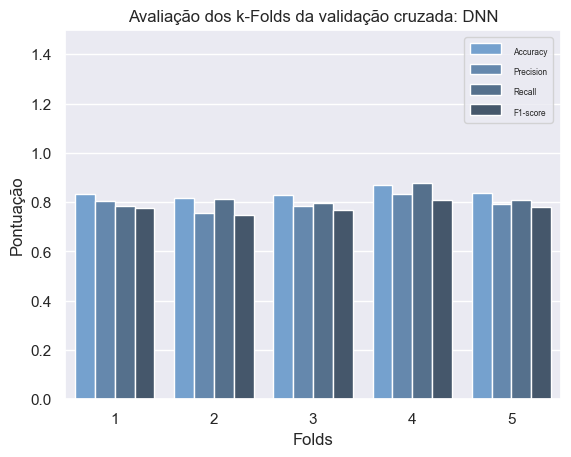

In [33]:
array = [] 
for i in range(k):
    array.append([i+1,folds[i].accuracy,'Accuracy'])
    array.append([i+1,folds[i].precision,'Precision'])
    array.append([i+1,folds[i].recall,'Recall'])
    array.append([i+1,folds[i].f1_score,'F1-score'])
    

column_values = ['fold','valor','metric']
df = pd.DataFrame(data = array,columns = column_values)

sns.set(rc={"figure.dpi":100, 'savefig.dpi':100})
sns.set_palette(sns.dark_palette("#66A1DD", reverse=True, as_cmap=False))


fig = sns.barplot(x='fold', y='valor', hue='metric', data=df)
plt.setp(fig.get_legend().get_texts(), fontsize='6') # for legend text
fig.legend_.set_title(None)

plt.xlabel("Folds")
plt.ylabel("Pontuação")
plt.title("Avaliação dos k-Folds da validação cruzada: DNN") 
plt.ylim(0,1.5)

plt.show(fig)


### Métricas na fase de testes

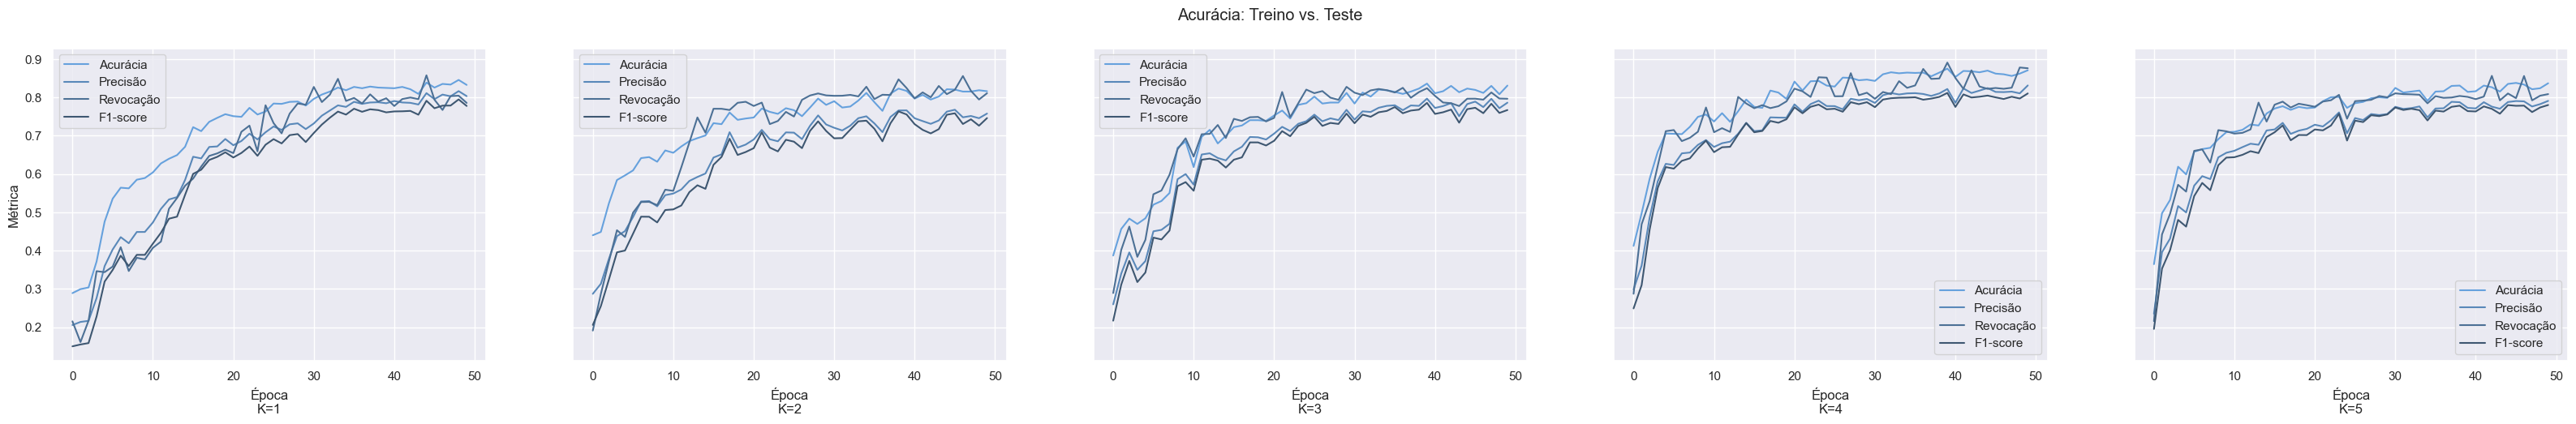

In [34]:
fig, axes = plt.subplots(1, k, figsize=(40, 5), sharey=True)
fig.suptitle('Acurácia: Treino vs. Teste')

i=0
for i in range(k):
    res= sns.lineplot(
            ax=axes[i],
            data=[
                folds[i].test_accuracy,
                folds[i].test_precision,            
                folds[i].test_recall,
                folds[i].test_f1_score,
                #folds[i].test_specificity
            ],
            markers=False, 
            dashes=False,   
            )
    
    res.set(xlabel='Época\nK={:d}'.format(i+1), ylabel='Métrica')
    res.legend(labels=["Acurácia","Precisão","Revocação","F1-score"])  
    #res.legend(labels=["Accuracy","Precision","Recall","Specificity","F1-score"])  

[Text(0.5, 104.87499999999999, 'Classe Prevista'),
 Text(314.875, 0.5, 'Classe Real')]

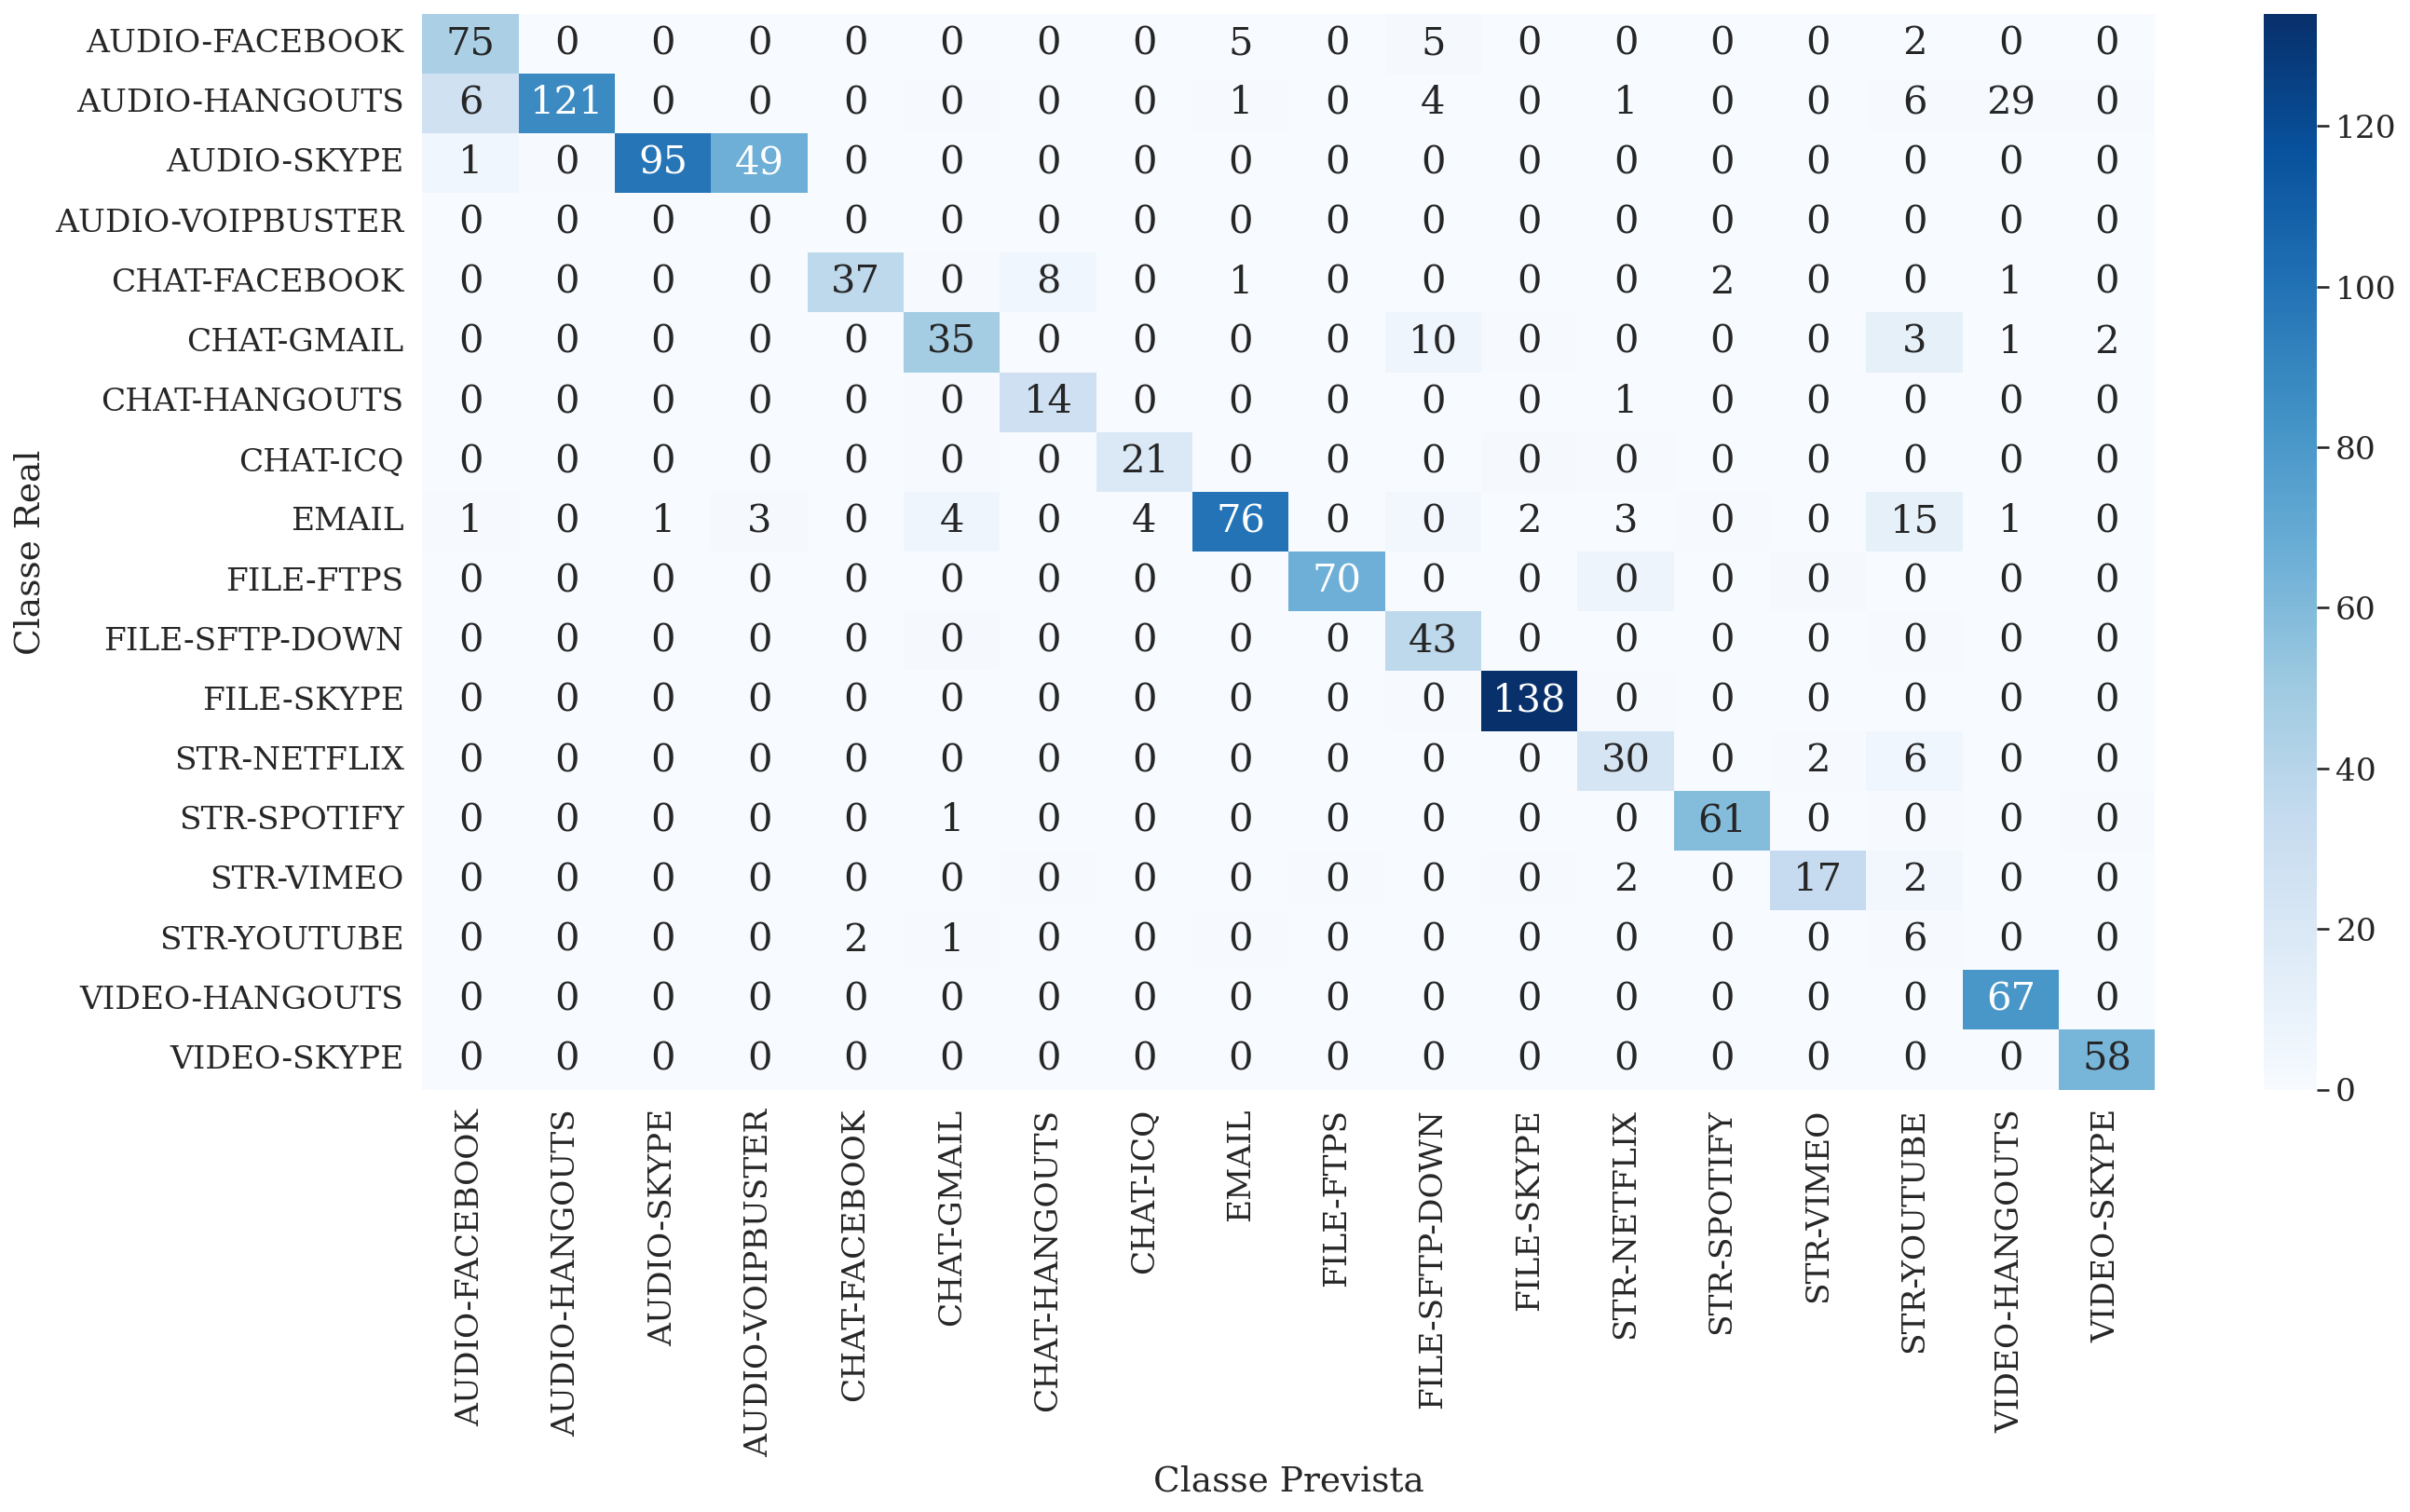

In [77]:
i=4

#----------------------------
plt.figure(figsize=(20, 10))
sns.set(rc={"figure.dpi":150, 'savefig.dpi':150})
sns.set(font_scale=1.5)
sns.set_style({'font.family':'serif', 'font.serif':['Times New Roman']})
res=sns.heatmap(folds[0].confusion_matrix,
                annot=folds[i].confusion_matrix,
                xticklabels=classe_label,
                yticklabels=classe_label,
                cmap="Blues",
                annot_kws={'size': 20},
                fmt='g')

res.set( xlabel="Classe Prevista",
        ylabel="Classe Real")

In [36]:
classe_label

array(['AUDIO-FACEBOOK', 'AUDIO-HANGOUTS', 'AUDIO-SKYPE',
       'AUDIO-VOIPBUSTER', 'CHAT-FACEBOOK', 'CHAT-GMAIL', 'CHAT-HANGOUTS',
       'CHAT-ICQ', 'EMAIL', 'FILE-FTPS', 'FILE-SFTP-DOWN', 'FILE-SKYPE',
       'STR-NETFLIX', 'STR-SPOTIFY', 'STR-VIMEO', 'STR-YOUTUBE',
       'VIDEO-HANGOUTS', 'VIDEO-SKYPE'], dtype=object)

### Matriz de confusão unificada

[90.78947368 74.39886846 60.47745358 25.         83.13253012 78.42323651
 94.         88.46153846 73.19422151 95.4787234  93.0875576  98.15340909
 71.0982659  96.62162162 77.51937984 68.         99.51923077 99.67948718]
                  precision    recall  f1-score   support

  AUDIO-FACEBOOK       0.74      0.91      0.82       304
  AUDIO-HANGOUTS       0.99      0.74      0.85       707
     AUDIO-SKYPE       0.99      0.60      0.75       754
AUDIO-VOIPBUSTER       0.00      0.25      0.01         4
   CHAT-FACEBOOK       0.98      0.83      0.90       249
      CHAT-GMAIL       0.74      0.78      0.76       241
   CHAT-HANGOUTS       0.75      0.94      0.84       100
        CHAT-ICQ       0.91      0.88      0.89       130
           EMAIL       0.95      0.73      0.83       623
       FILE-FTPS       0.98      0.95      0.97       376
  FILE-SFTP-DOWN       0.75      0.93      0.83       217
      FILE-SKYPE       0.99      0.98      0.99       704
     STR-NETFLIX       0.

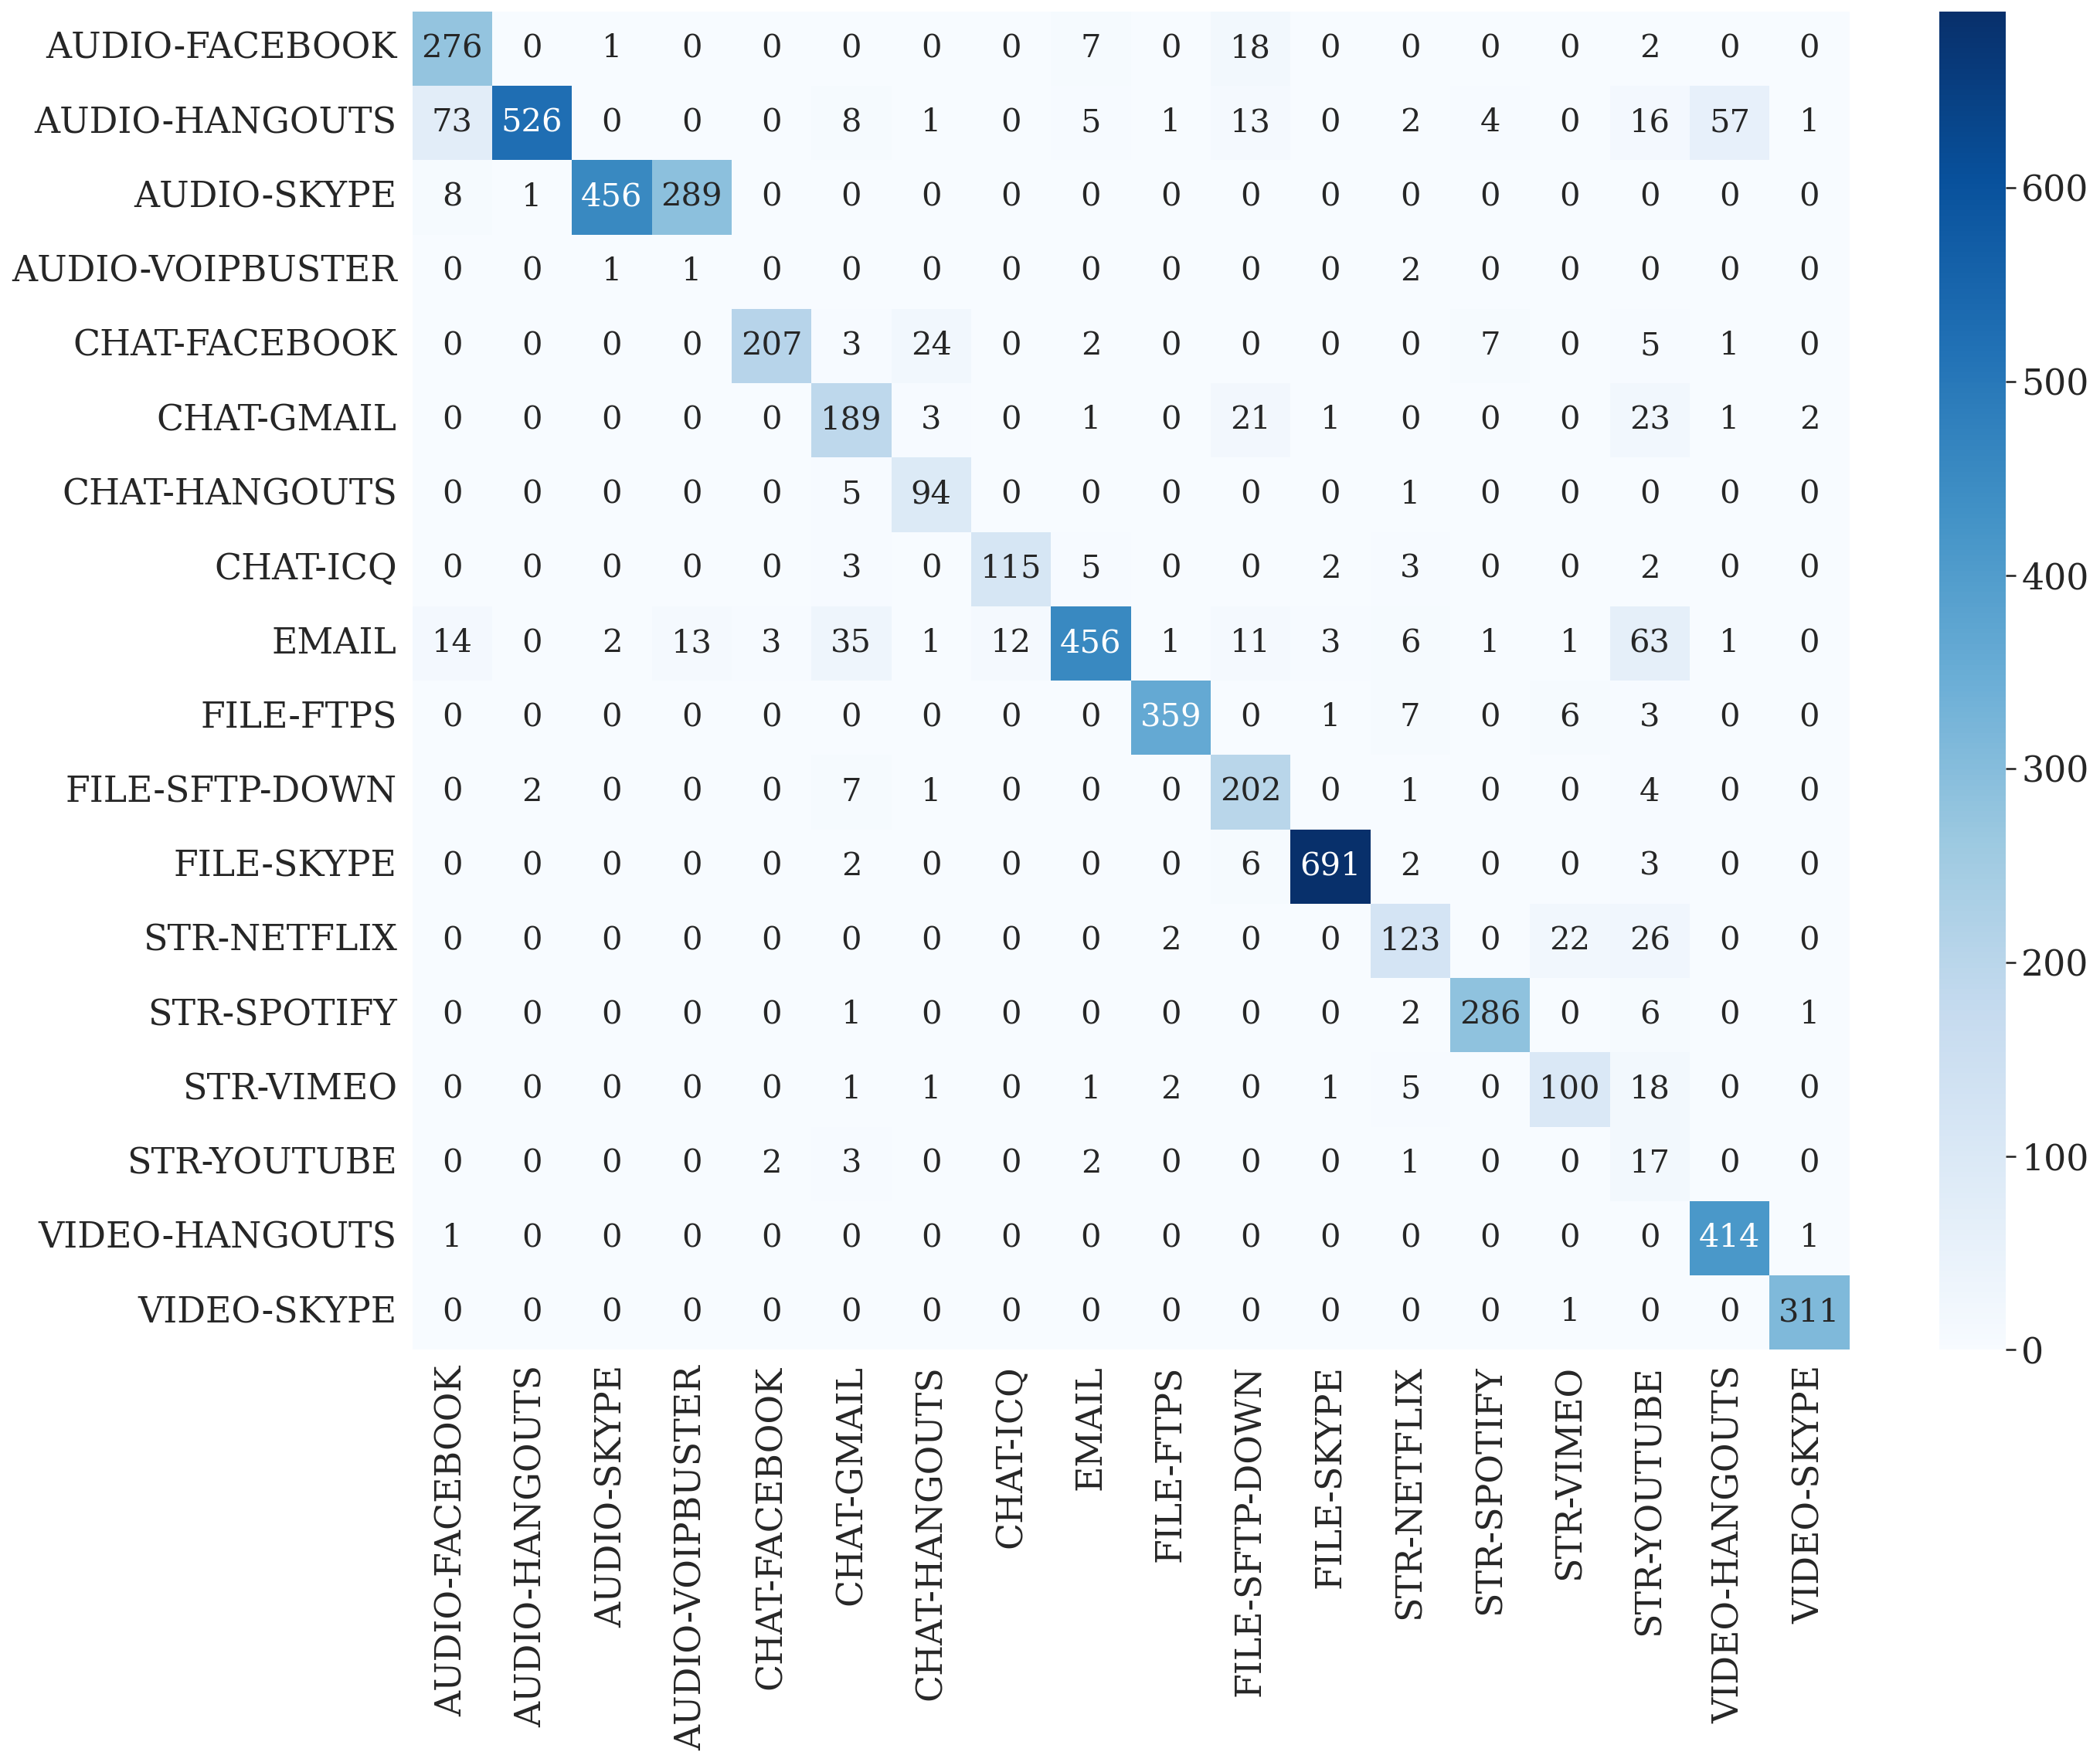

In [63]:
last_true_all = np.array([], dtype=int) 
last_pred_all = np.array([], dtype=int) 
last_score_all = np.empty((0,n_classes), float)


i=0
for i in range(k):
    last_true_all  = np.append(last_true_all,folds[i].last_true)
    last_pred_all  = np.append(last_pred_all,folds[i].last_pred)
    
    last_score_all = np.append(last_score_all,folds[i].last_score,axis=0)

global_confusion_matrix= confusion_matrix(last_true_all,last_pred_all)    


cmat = global_confusion_matrix
print(cmat.diagonal()/cmat.sum(axis=1)*100)
    
i=0
sns.set(rc={"figure.dpi":150, 'savefig.dpi':150})
sns.set_context('notebook')
sns.set_style("darkgrid")
sns.set(font_scale=2)
sns.set_style({'font.family':'serif', 'font.serif':['Times New Roman']})

plt.figure(figsize=(20, 15))

plt.ylabel("Pontuação")
sns.heatmap(global_confusion_matrix,annot=global_confusion_matrix,xticklabels=classe_label,
            yticklabels=classe_label,
            cmap="Blues",
            annot_kws={'size': 20},
            fmt='g')


clf_report=classification_report(last_true_all, last_pred_all, target_names=classe_label)

print(clf_report)


#fig, axes = plt.subplots(1, 1, figsize=(10, 30), sharey=True)
#fig.suptitle('Acurácia: Treino vs. Teste')


#clf_report =classification_report(last_true_all, last_pred_all, target_names=classe_label,output_dict=True)
 
#res= sns.heatmap(annot = True,
#                data= pd.DataFrame(clf_report).iloc[:-1, :].T,
#                 cmap="Blues",
#            annot_kws={'size': 30},
#            fmt=".2%") 
#res.set(xlabel='Época\nK={:d}'.format(i+1), ylabel='Métrica')
#res.legend(labels=["Accuracy","Precision","Recall","F1-score"]) 

### Etapa 1: Curva ROC

In [38]:
i=0
j=0
n_samples= last_true_all.shape[0]
x = torch.Tensor(last_true_all)


# Create list n_samples random labels (can also be numpy array)
labels = [random.randrange(n_classes) for _ in range(n_samples)]
# Convert to torch Tensor 
labels_tensor = torch.as_tensor(labels)
# Create one-hot encodings of labels 
y_one_hot = torch.nn.functional.one_hot(x.to(torch.int64),  num_classes=n_classes)
#print(y_one_hot)


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    
    fpr[i], tpr[i], _ = roc_curve(y_one_hot[:, i],last_score_all[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    #print(roc_auc[i],fpr[i], tpr[i])
    #print('\n')
    

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_one_hot.ravel(), last_score_all.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

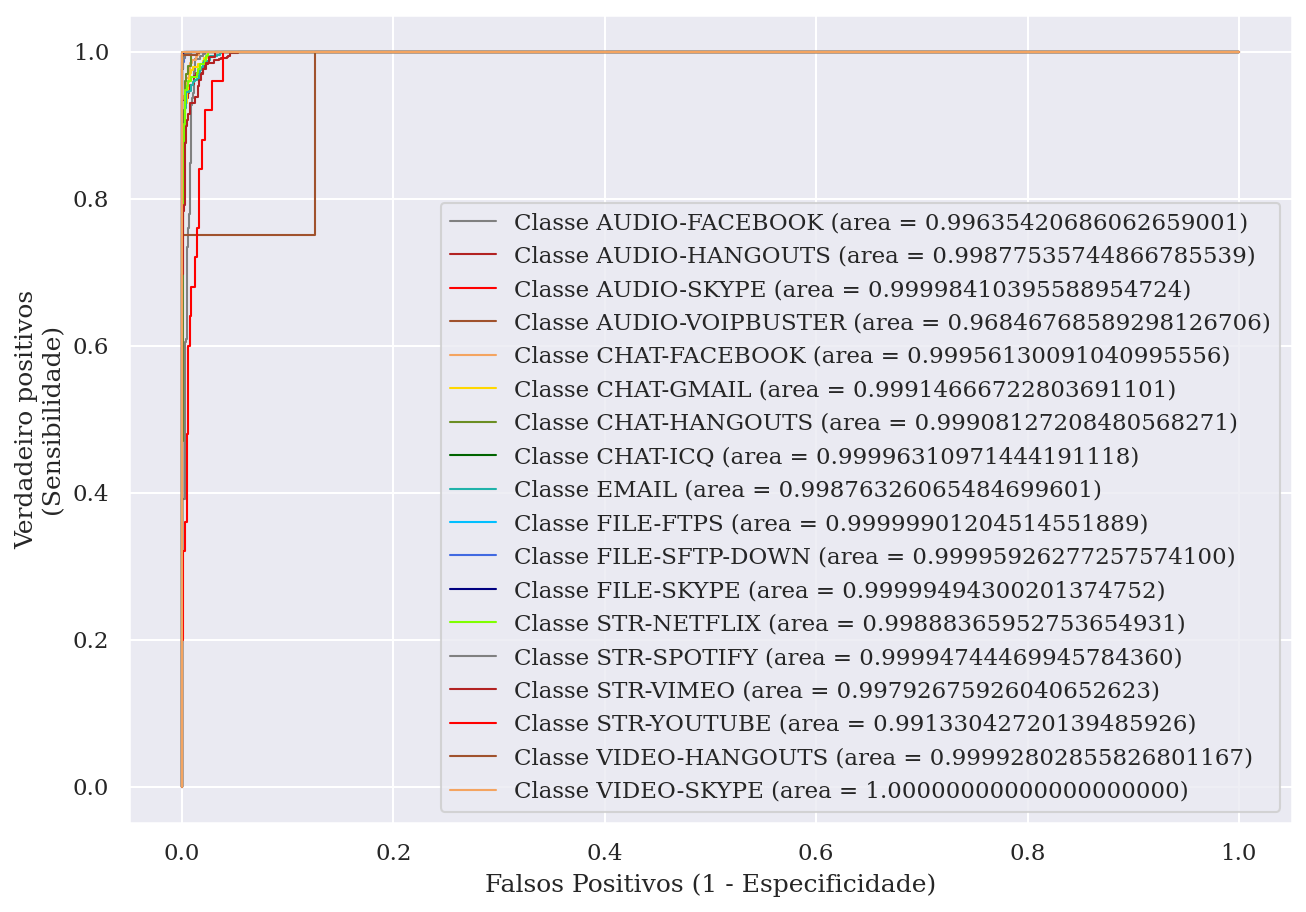

In [51]:
lw = 1 # line_width

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(10,7))
#plt.plot(fpr["micro"], tpr["micro"],
#         label='micro-average ROC curve (area = {0:0.2f})'
#               ''.format(roc_auc["micro"]),
#         color='deeppink', linestyle=':', linewidth=4)

#plt.plot(fpr["macro"], tpr["macro"],
#         label='macro-average ROC curve (area = {0:0.2f})'
#               ''.format(roc_auc["macro"]),
#         color='navy', linestyle=':', linewidth=4)

colors = cycle(['gray','firebrick','red','sienna','sandybrown', 'gold',
                'olivedrab','darkgreen','lightseagreen','deepskyblue','royalblue','navy',
                'chartreuse'
               ])
sns.set(rc={"figure.dpi":150, 'savefig.dpi':150})
sns.set_context('notebook')
sns.set_style("darkgrid")
sns.set(rc={"figure.figsize":(6, 4)})
sns.set_style({'font.family':'serif', 'font.serif':['Times New Roman']})

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw, label='Classe {0} (area = {1:0.20f})'
             ''.format(classe_label[i], roc_auc[i]))
    
plt.xlabel('Falsos Positivos (1 - Especificidade)')
plt.ylabel('Verdadeiro positivos\n(Sensibilidade)')
#plt.title('Curva ROC Multiclasse')
plt.legend(loc="lower right")

plt.show()

In [40]:
folds[0].confusion_matrix

array([[ 45,   0,   0,   0,   0,   0,   0,   0,   0,   0,   2,   0,   0,
          0,   0,   0,   0,   0],
       [ 27,  87,   0,   0,   0,   1,   0,   0,   1,   0,   0,   0,   0,
          0,   0,   1,   1,   1],
       [  5,   1,  98,  66,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0],
       [  0,   0,   0,   0,  37,   1,   5,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  48,   0,   0,   0,   0,   6,   1,   0,
          0,   0,  12,   0,   0],
       [  0,   0,   0,   0,   0,   1,  28,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   1,   0,  19,   0,   0,   0,   2,   1,
          0,   0,   0,   0,   0],
       [  1,   0,   0,   2,   0,   6,   0,   0,  99,   0,   4,   0,   0,
          1,   0,  12,   0,   0],
       [  0,   0,   0,   0,   0,   0,

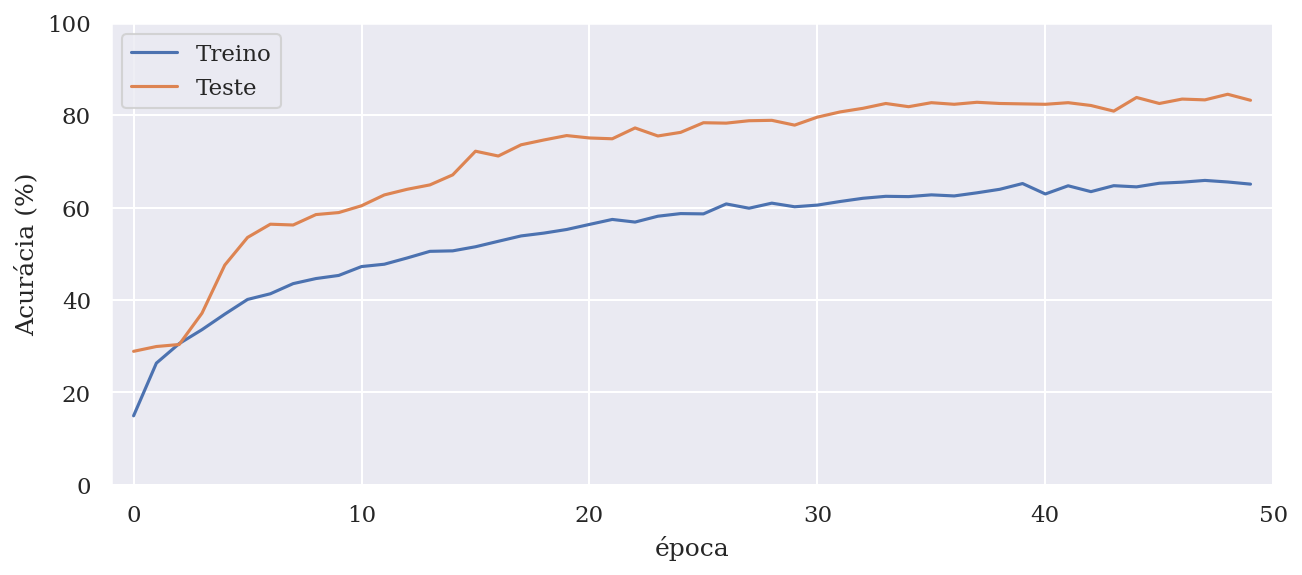

In [41]:
i=0
sns.set(rc={"figure.dpi":150, 'savefig.dpi':150})
sns.set_style("darkgrid",{'font.family':'serif', 'font.serif':['Times New Roman']})


plt.figure(figsize=(10,4))
plt.ylim(0, 1)
plt.xlim(-1, epochs)

res= sns.lineplot(
        data=[folds[i].train_accuracy,
            folds[i].test_accuracy ],
        markers=False, 
        dashes=False,   
        )
res.legend(labels=["Treino","Teste"]) 
res.set(xlabel='época', ylabel='Acurácia (%)'.format("0.2f"))
_ = res.set_yticklabels(map('{:.0f}'.format, 100*res.yaxis.get_majorticklocs()))    




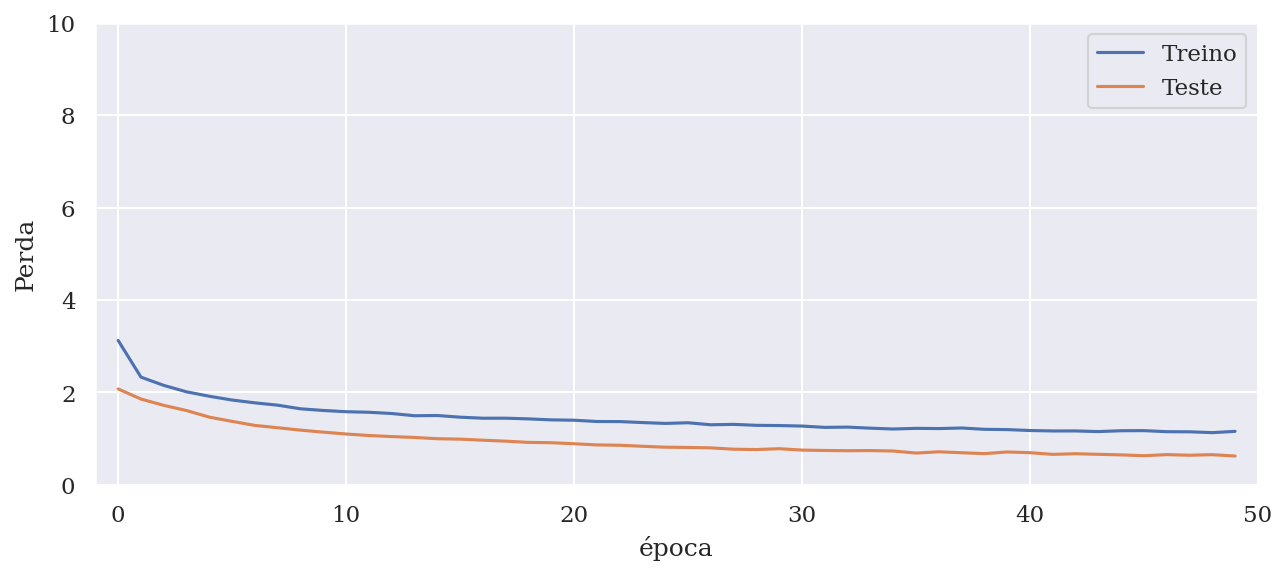

In [42]:
i=4

sns.set(rc={"figure.dpi":150, 'savefig.dpi':150})
sns.set_style("darkgrid",{'font.family':'serif', 'font.serif':['Times New Roman']})

plt.figure(figsize=(10,4))
plt.ylim(0, 10)
plt.xlim(-1, epochs)



res= sns.lineplot(
    data=[
        folds[i].train_loss,
        folds[i].test_loss],
    markers=False, 
    dashes=False,
    )

res.set(xlabel='época', ylabel='Perda')
res.legend(labels=["Treino","Teste"])

In [43]:
print("{:0.10f};{:0.10f};{:0.10f};{:0.10f}".format(np.mean(total_accuracy),np.mean(total_precision),np.mean(total_recall),np.mean(total_f1_score)))


0.8373263889;0.7937732720;0.8154183718;0.7761135973


(0.0, 1.0)

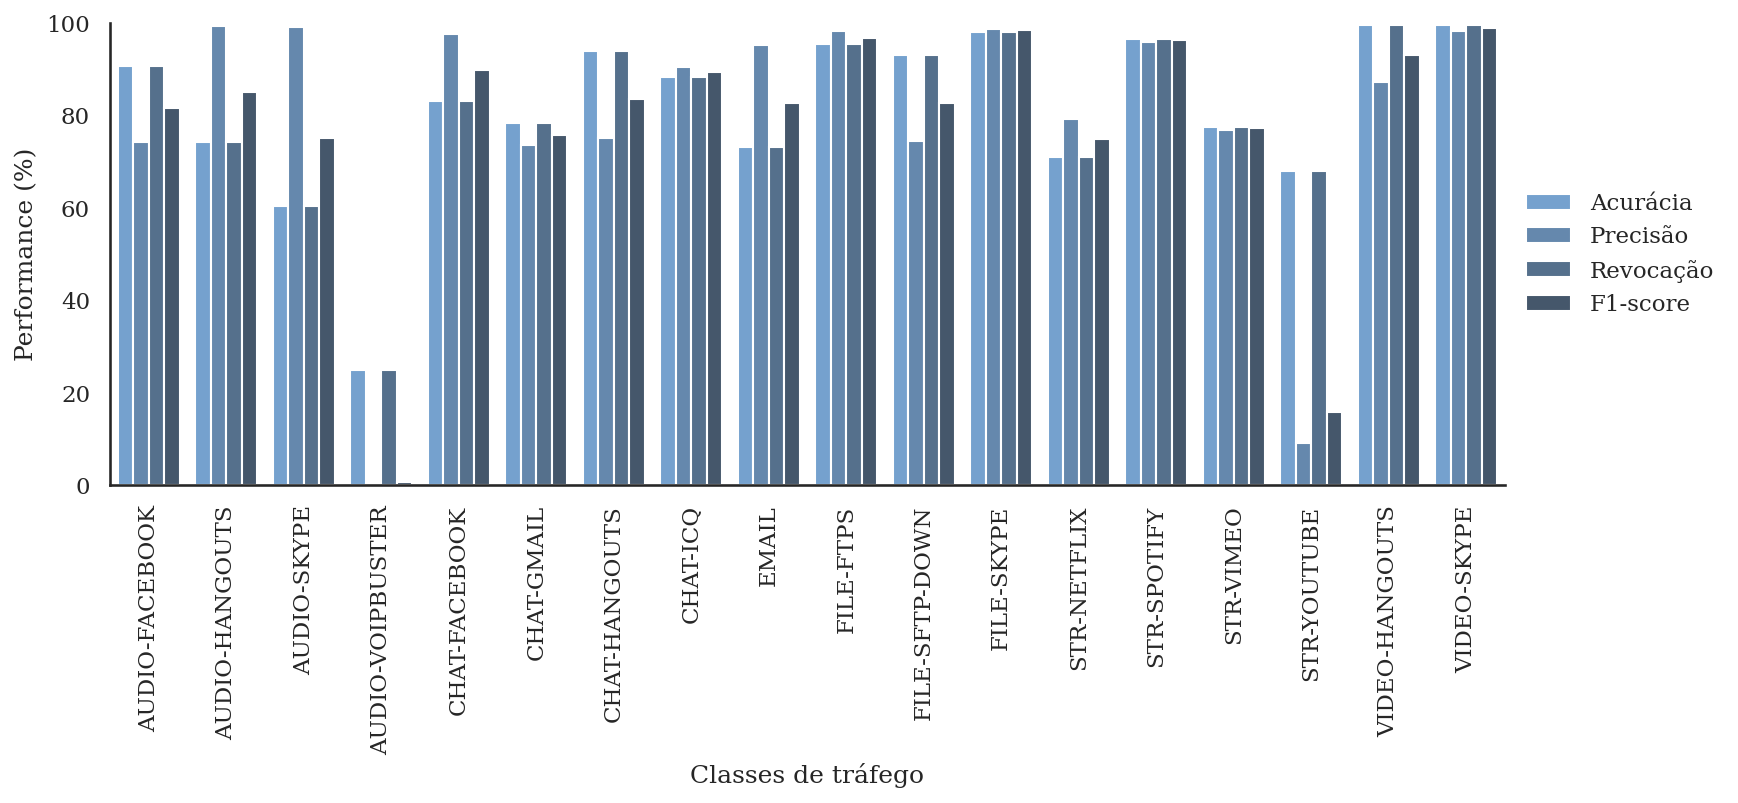

In [44]:
clf_report =classification_report(last_true_all, last_pred_all, target_names=classe_label,output_dict=True)
accuracy_total=global_confusion_matrix.diagonal()/global_confusion_matrix.sum(axis=1)
temp_array = [] 
i=0
for x in classe_label:
    temp_array.append([x,accuracy_total[i],'Acurácia'])
    temp_array.append([x,clf_report[x]['precision'],'Precisão'])
    temp_array.append([x,clf_report[x]['recall'],'Revocação'])
    temp_array.append([x,clf_report[x]['f1-score'],'F1-score'])
    i+=1

column_values = ['class','valor','metric']
df = pd.DataFrame(data = temp_array,columns = column_values)

#plt.figure(figsize=(12, 4))

sns.set(rc={"figure.dpi":150, 'savefig.dpi':150})
sns.set(rc={"figure.figsize":(12, 4)})
sns.set_palette(sns.dark_palette("#66A1DD", reverse=True, as_cmap=False))
sns.set_style("white")
sns.set_style({'font.family':'serif', 'font.serif':['Times New Roman']})

res = sns.barplot(x='class', y='valor', hue='metric', data=df)
res.set_xticklabels(res.get_xticklabels(),rotation=90)
res.legend(loc='center left', bbox_to_anchor=(1, 0.5),frameon=False)    

_ = res.set_yticklabels(map('{:.0f}'.format, 100*res.yaxis.get_majorticklocs()))    

res.spines.right.set_visible(False)
res.spines.top.set_visible(False)

res.legend_.set_title(None)

plt.xlabel("Classes de tráfego")
plt.ylabel("Performance (%)")
plt.ylim(0,1)



In [45]:
accuracy_stack

array([0.83246528, 0.81597222, 0.83072917, 0.87065972, 0.83680556])

In [46]:
folds[4].confusion_matrix

array([[ 75,   0,   0,   0,   0,   0,   0,   0,   5,   0,   5,   0,   0,
          0,   0,   2,   0,   0],
       [  6, 121,   0,   0,   0,   0,   0,   0,   1,   0,   4,   0,   1,
          0,   0,   6,  29,   0],
       [  1,   0,  95,  49,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0],
       [  0,   0,   0,   0,  37,   0,   8,   0,   1,   0,   0,   0,   0,
          2,   0,   0,   1,   0],
       [  0,   0,   0,   0,   0,  35,   0,   0,   0,   0,  10,   0,   0,
          0,   0,   3,   1,   2],
       [  0,   0,   0,   0,   0,   0,  14,   0,   0,   0,   0,   0,   1,
          0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,  21,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0],
       [  1,   0,   1,   3,   0,   4,   0,   4,  76,   0,   0,   2,   3,
          0,   0,  15,   1,   0],
       [  0,   0,   0,   0,   0,   0,

In [47]:
accuracy_stack.mean()

0.8373263888888889